## Resumen de la revisión v1 <a class="tocSkip"></a>

----

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

## Paso 1. Abre el archivo de datos y estudia la información general 

In [47]:
df_games = pd.read_csv('games.csv')

In [48]:
df_games.info()
df_games.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## Paso 2. Prepara los datos

In [49]:
# Reemplaza los nombres de las columnas (ponlos en minúsculas).

lowered_columns = []

for col in df_games.columns:
    lowered_columns.append(col.lower())

df_games.columns = lowered_columns
df_games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [50]:
# Convierte los datos en los tipos necesarios.

df_games['user_score'] = (
    df_games['user_score']
      .replace('tbd', np.nan)
      .astype('float64')
)
df_games['year_of_release'] = (
    pd.to_numeric(df_games['year_of_release'], errors='coerce')
      .astype('Int64')
)

df_games['critic_score'] = (
    pd.to_numeric(df_games['critic_score'], errors='coerce')
      .astype('Int64')
)

df_games[['name', 'rating','platform','genre']] = df_games[['name', 'rating','platform','genre']].replace(r'^\s*$', np.nan, regex=True)

for col in ['platform', 'genre', 'rating']:
        df_games[col] = df_games[col].astype('category')

df_games['name'] = df_games['name'].astype('string')

print(df_games.dtypes)
print(df_games.isna().sum())

name               string[python]
platform                 category
year_of_release             Int64
genre                    category
na_sales                  float64
eu_sales                  float64
jp_sales                  float64
other_sales               float64
critic_score                Int64
user_score                float64
rating                   category
dtype: object
name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64


name: originalmente era object pero string facilita el manejo de texto y nulos.

platform,genre y rating: son variables con pocos valores posibles por lo que conviene trabajarlos como categorías.

year_of_release: originalmente eran de tipo float pero todos los años son enteros.

user_score: llegaba como tipo object pero conviene cambiarlo a tipo numerico y cambiar los 'tbd' por NaN.

critic_score: originalmente es tipo float pero todos los valores son enteros.

Las columnas correspondientes a las ventas están bien en tipo float.

Posibles causas de los valores faltantes: 
name: 
-caracteres especiales que se perdieron al leer el csv.

year_of_release: 
-puede ser que la información se haya registrado con anterioridad al lanzamiento del  titulo. 
-Tipos de datos no convertidos.

rating: 
-El titulo no tuvo suficientes calificaciones debido a poca promoción, lanzamiento    reciente, etc...

genre: pueden ser juegos sin un genero especifico.

In [51]:
# Calcula las ventas totales (la suma de las ventas en todas las regiones) 
# para cada juego y coloca estos valores en una columna separada.

df_games['global_sales'] = df_games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)
df_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN,31.38


## Paso 3. Analiza los datos

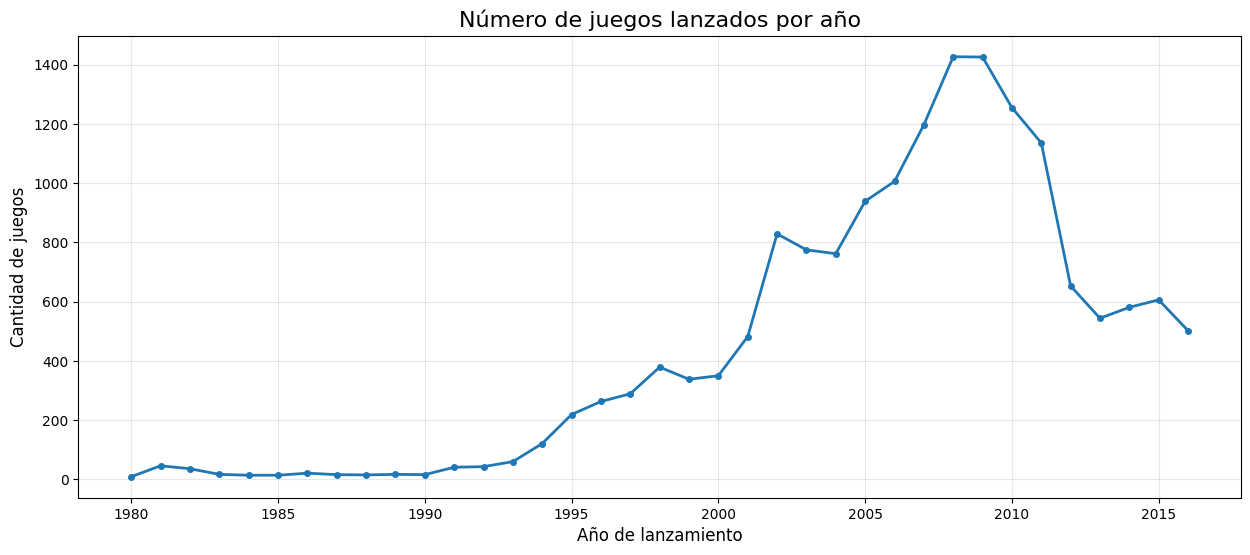

In [52]:
# Mira cuántos juegos fueron lanzados en diferentes años. 

games_per_year = df_games.groupby('year_of_release')['name'].count()
plt.figure(figsize=(15, 6))

games_per_year.plot(kind='line', marker='o', linewidth=2, markersize=4)
plt.title('Número de juegos lanzados por año', fontsize=16)
plt.xlabel('Año de lanzamiento', fontsize=12)
plt.ylabel('Cantidad de juegos', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

¿Son significativos los datos de cada período?

Parece que de 1980 a 1994 no hubo suficientes lanzamientos como para considerar que los datos sean significativos o relevantes.

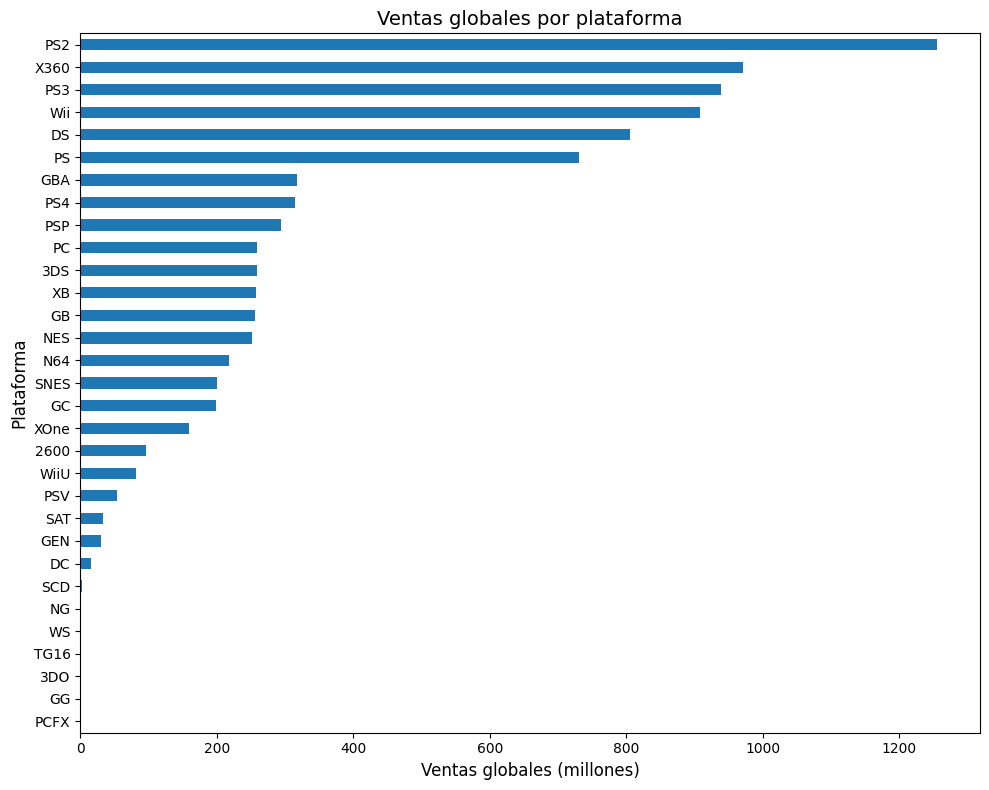

In [53]:
# Observa cómo varían las ventas de una plataforma a otra. 

sales_per_platform = (
    df_games.groupby('platform')['global_sales']
        .sum()
        .sort_values(ascending=True)
)


plt.figure(figsize=(10, 8))
sales_per_platform.plot(kind='barh')
plt.title('Ventas globales por plataforma', fontsize=14)
plt.xlabel('Ventas globales (millones)', fontsize=12)
plt.ylabel('Plataforma', fontsize=12)
plt.tight_layout()
plt.show()

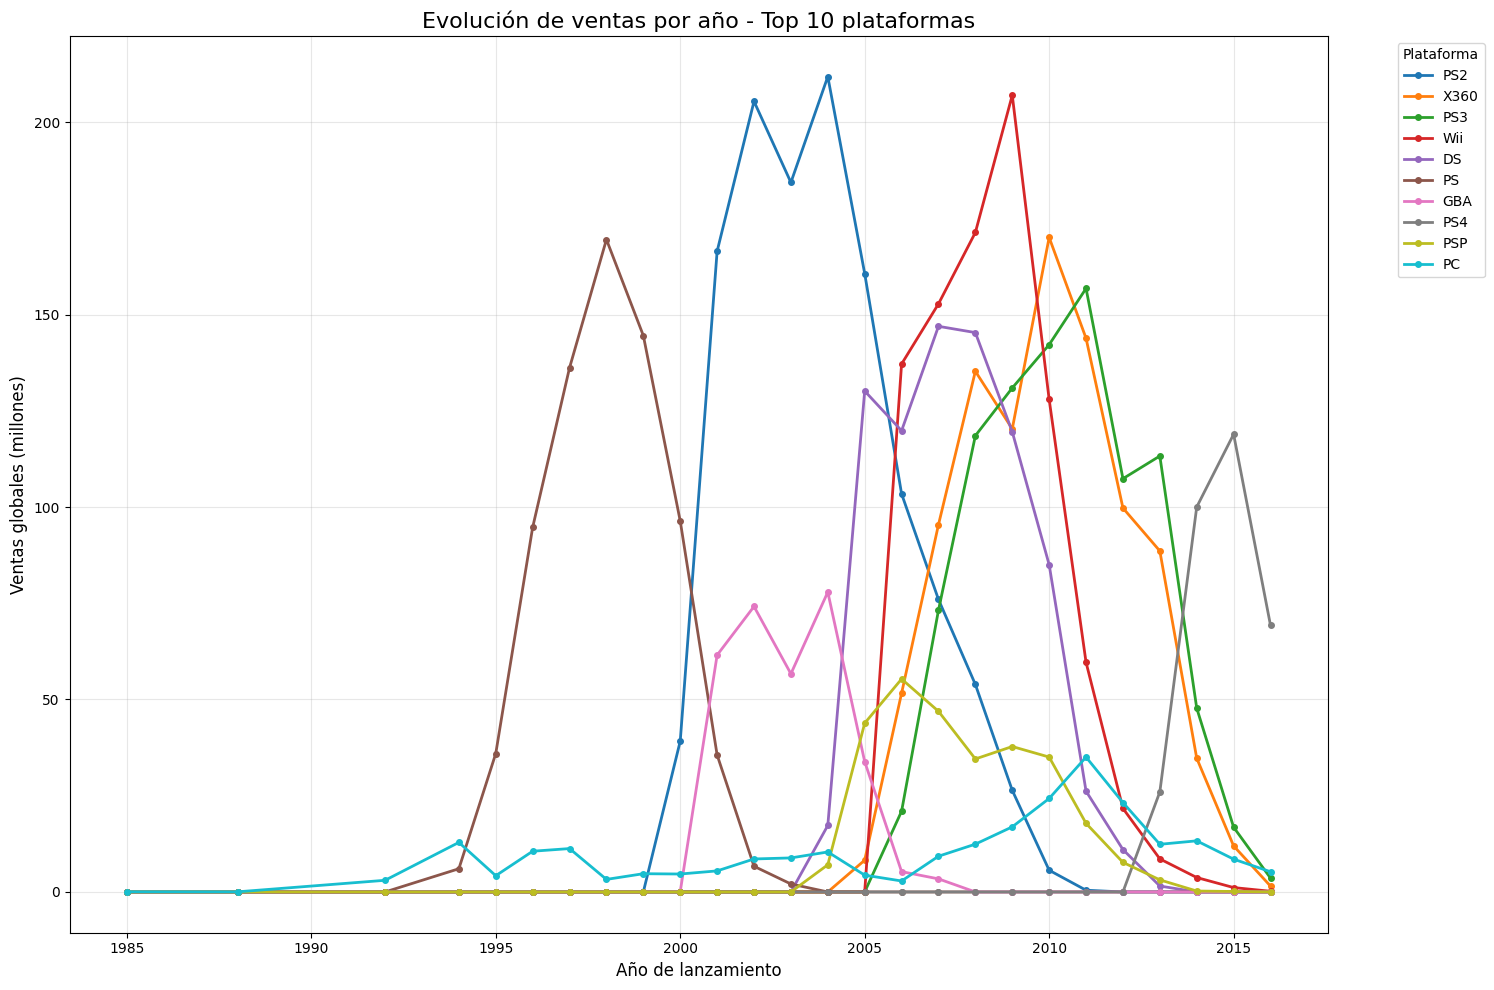

In [54]:
# Elige las plataformas con las mayores ventas totales.

sales_per_platform = (
    df_games.groupby('platform', observed=True)['global_sales']
            .sum()
            .sort_values(ascending=False)
)
top_platforms = sales_per_platform.head(10).index.tolist()

sales_by_year_platform = (
    df_games[df_games['platform'].isin(top_platforms)]
      .groupby(['year_of_release', 'platform'], observed=True)['global_sales']
      .sum()
      .unstack(fill_value=0)
      .reindex(columns=top_platforms)
      .sort_index()
)

# construye una distribución basada en los datos de cada año. 

ax = sales_by_year_platform.plot(figsize=(15,10), kind='line', marker='o', linewidth=2, markersize=4)
ax.set_title('Evolución de ventas por año - Top 10 plataformas', fontsize=16)
ax.set_xlabel('Año de lanzamiento', fontsize=12)
ax.set_ylabel('Ventas globales (millones)', fontsize=12)
ax.legend(title='Plataforma', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [55]:
# Busca las plataformas que solían ser populares pero que ahora no tienen ventas. 

periodo_temprano = df_games[df_games['year_of_release'] <= 2011]
periodo_tardio = df_games[df_games['year_of_release'] >= 2012]

ventas_temprano = periodo_temprano.groupby('platform')['global_sales'].sum().sort_values(ascending=False)
ventas_tardio = periodo_tardio.groupby('platform')['global_sales'].sum().sort_values(ascending=False)

comparacion = pd.DataFrame({
    'ventas_2007_2011': ventas_temprano,
    'ventas_2012_2016': ventas_tardio
}).fillna(0)

comparacion['cambio_porcentual'] = ((comparacion['ventas_2012_2016'] - comparacion['ventas_2007_2011']) / 
                   
                comparacion['ventas_2007_2011'] * 100)

mayor_caida_porcentual = comparacion[
    (comparacion['ventas_2007_2011'] > 20) &      
    (comparacion['cambio_porcentual'] < 0)        
].sort_values('cambio_porcentual')                

print("Plataformas con mayor caída porcentual:")
print(mayor_caida_porcentual[['ventas_2007_2011', 'ventas_2012_2016', 'cambio_porcentual']].head(30))

Plataformas con mayor caída porcentual:
          ventas_2007_2011  ventas_2012_2016  cambio_porcentual
platform                                                       
2600                 86.48              0.00        -100.000000
SNES                200.04              0.00        -100.000000
SAT                  33.59              0.00        -100.000000
PS2                1233.56              0.00        -100.000000
PS                  727.58              0.00        -100.000000
NES                 251.05              0.00        -100.000000
XB                  251.57              0.00        -100.000000
GEN                  30.77              0.00        -100.000000
GC                  196.73              0.00        -100.000000
GBA                 312.88              0.00        -100.000000
GB                  254.43              0.00        -100.000000
N64                 218.01              0.00        -100.000000
DS                  790.23             12.55         -98.411855


In [56]:
# ¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer?

first_year = df_games.groupby('platform')['year_of_release'].min()
last_year = df_games.groupby('platform')['year_of_release'].max()

platform_lifecycle = pd.DataFrame({
    'first_year': first_year,
    'last_year': last_year,
    'life_cycle': last_year - first_year
}).reset_index()

platform_lifecycle = platform_lifecycle[platform_lifecycle['life_cycle'] >= 1]
avg_life_filtered = platform_lifecycle['life_cycle'].mean()

print(f"Ciclo de vida promedio (Consolas con mas de 1 año de vida): {avg_life_filtered:.2f} años")

Ciclo de vida promedio (Consolas con mas de 1 año de vida): 8.43 años


In [57]:
# Trabaja solo con los datos que consideras relevantes. Ignora los datos de años anteriores.

df_games_filtered = df_games[df_games['year_of_release'] >= 2007].reset_index()
df_games_filtered.head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
0,2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
1,3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
2,8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87,8.4,E,28.32
3,13,Wii Fit,Wii,2007,Sports,8.92,8.03,3.60,2.15,80,7.7,E,22.70
4,14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61,6.3,E,21.82


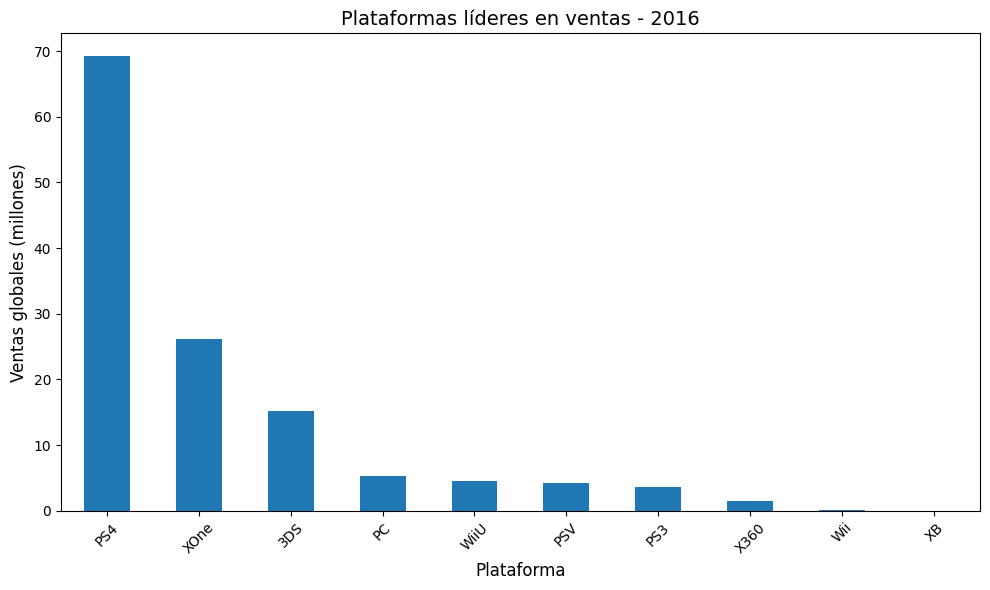

In [58]:
# ¿Qué plataformas son líderes en ventas? ¿Cuáles crecen y cuáles se reducen? Elige varias plataformas potencialmente rentables.

actual = df_games_filtered[df_games_filtered['year_of_release'] == 2016]
actual_lead_sellers = actual.groupby('platform')['global_sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
actual_lead_sellers.head(10).plot(kind='bar')
plt.title('Plataformas líderes en ventas - 2016', fontsize=14)
plt.xlabel('Plataforma', fontsize=12)
plt.ylabel('Ventas globales (millones)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


En la actualidad podemos apreciar una clara diferencia entre plataformas como PS4 y XOne que presentan un momentum positivo y reciente en comparación con todas las demás plataformas que claramente se encuentran al final de su ciclo de vida. En este sentido esas dos plataformas y quizás 3DS aunque en menor medida, representan las opciones mas rentables y con una mejor proyección a futuro.

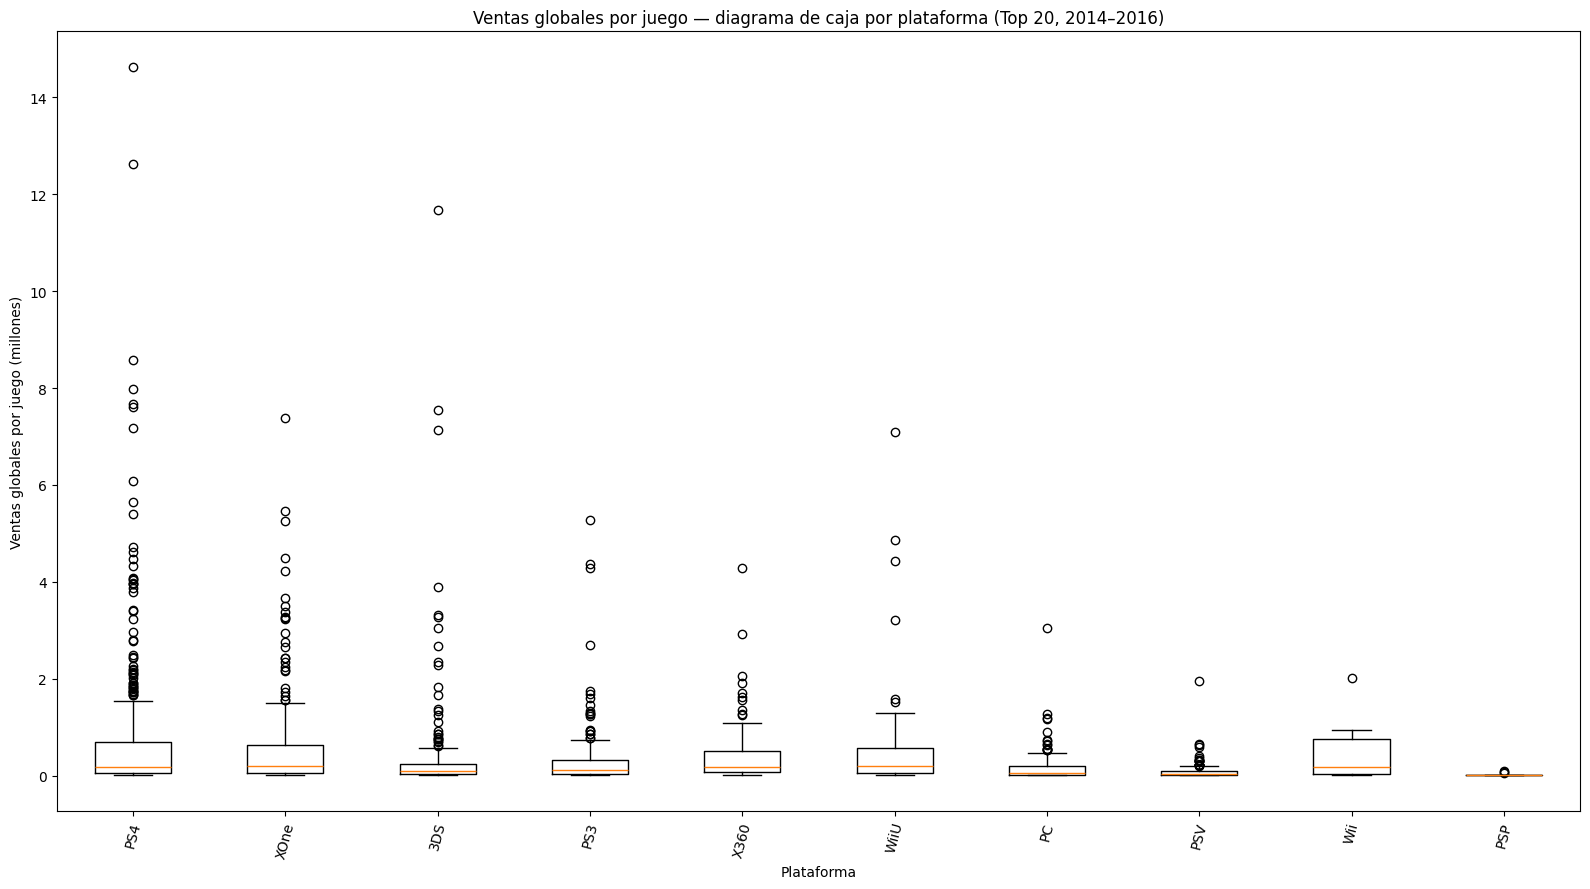

,platform,count,mean,median,std,min,max
0,3DS,212,0.408868,0.090,1.188368,0.01,11.68
1,PC,151,0.179139,0.060,0.329359,0.01,3.05
2,PS3,219,0.311324,0.110,0.633059,0.01,5.27
3,PS4,376,0.766356,0.185,1.614969,0.01,14.63
4,PSP,13,0.027692,0.020,0.027735,0.01,0.09
5,PSV,295,0.075932,0.040,0.141591,0.01,1.96
6,Wii,11,0.460909,0.180,0.625451,0.01,2.01
7,WiiU,73,0.588767,0.190,1.161467,0.01,7.09
8,X360,111,0.434414,0.180,0.628967,0.01,4.28
9,XOne,228,0.615614,0.205,1.046513,0.01,7.39


In [59]:
# Crea un diagrama de caja para las ventas globales de todos los juegos, desglosados por plataforma. 

df = df_games_filtered.copy()
df['platform'] = df['platform'].astype('string')

df_period = df[df['year_of_release'].between(2014, 2016, inclusive='both')] \
             .dropna(subset=['platform','global_sales'])

total_by_platform_period = (df_period.groupby('platform', observed=True)['global_sales']
                              .sum().sort_values(ascending=False))
top20 = total_by_platform_period.head(20).index.tolist()

df_top = df_period[df_period['platform'].isin(top20)].copy()

stats = (df_top.groupby('platform', observed=True)['global_sales']
           .agg(['count','mean','median','std','min','max'])
           .reset_index())

platform_order = [p for p in top20 if p in stats['platform'].values]
data = [df_top.loc[df_top['platform'] == p, 'global_sales'].values for p in platform_order]

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
plt.boxplot(data, labels=platform_order, showfliers=True)
plt.title('Ventas globales por juego — diagrama de caja por plataforma (Top 20, 2014–2016)')
plt.xlabel('Plataforma'); plt.ylabel('Ventas globales por juego (millones)')
plt.xticks(rotation=75); plt.tight_layout(); plt.show()

stats

¿Son significativas las diferencias en las ventas? 

Sí, las diferencias son sustanciales entre plataformas. Las medianas no coinciden y los rangos intercuartílicos varían mucho.

Las distribuciones de cada plataforma difieren mucho. Algunas son muy compactas y casi sin ningún dato atipico y otras presentan una mayor dispersión.

¿Qué sucede con las ventas promedio en varias plataformas?

La media está muy influida por pocos mega-hits; por eso verás plataformas cuya media es mayor que la mediana de forma marcada.

Plataformas actuales en 2014–2016 suelen mostrar medianas y medias más altas que las de ciclo tardío.

Las portátiles tienden a tener medianas moderadas y dispersión media, con menos hits que eleven la media.

In [60]:
# Mira cómo las reseñas de usuarios y profesionales afectan las ventas de una plataforma popular (tu elección). 

df_ps4 = df_games[df_games['platform'] == 'PS4']
df_ps4['user_score'] = pd.to_numeric(df_ps4['user_score'], errors='coerce')
df_ps4['critic_score'] = pd.to_numeric(df_ps4['critic_score'], errors='coerce')
df_ps4_clean = df_ps4.dropna(subset=['critic_score', 'user_score'])
stats = df_ps4_clean[['critic_score','user_score']].agg(['count','mean','median','std','min','max']).reset_index()




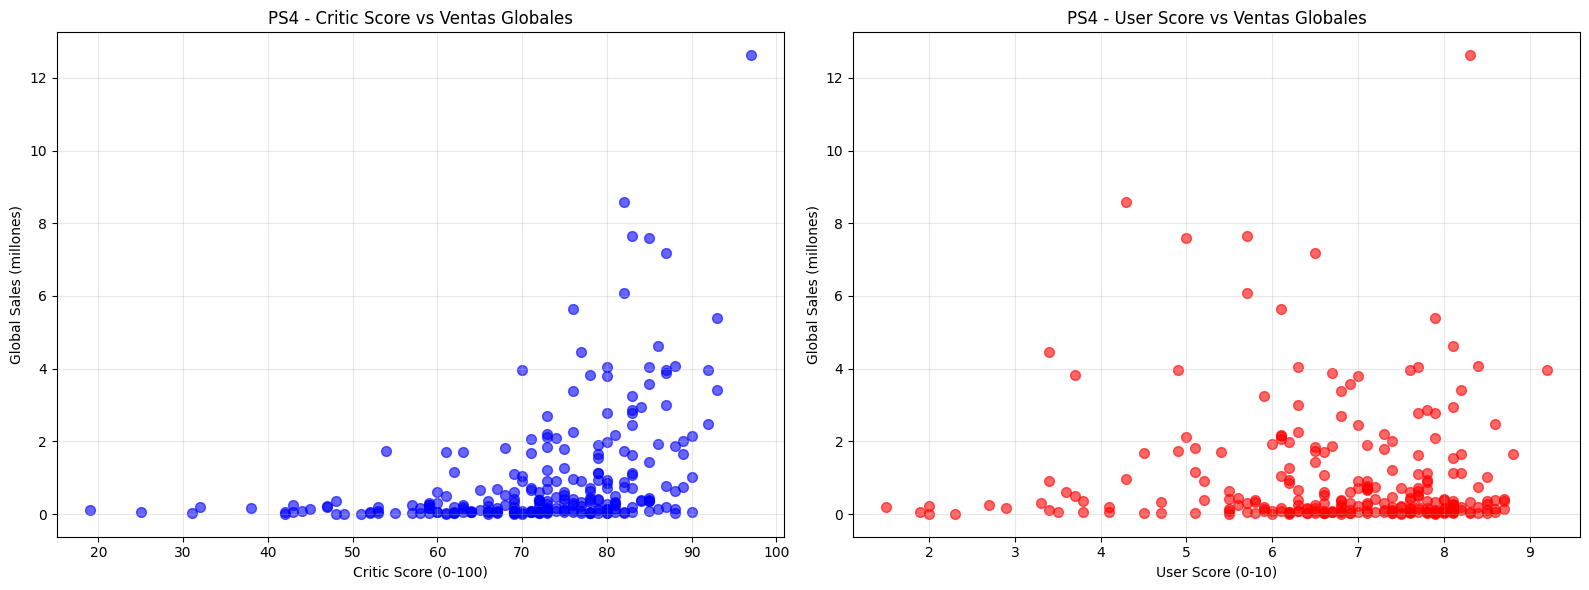

Correlación Critic Score vs Global Sales: 0.406
Correlación User Score vs Global Sales: -0.034


In [61]:
# Crea un gráfico de dispersión y calcula la correlación entre las reseñas y las ventas. Saca conclusiones.

df = df_ps4_clean.copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(df['critic_score'], df['global_sales'], alpha=0.6, s=50, color='blue')
ax1.set_xlabel('Critic Score (0-100)')
ax1.set_ylabel('Global Sales (millones)')
ax1.set_title('PS4 - Critic Score vs Ventas Globales')
ax1.grid(True, alpha=0.3)

ax2.scatter(df['user_score'], df['global_sales'], alpha=0.6, s=50, color='red')
ax2.set_xlabel('User Score (0-10)')
ax2.set_ylabel('Global Sales (millones)')
ax2.set_title('PS4 - User Score vs Ventas Globales')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

corr_critic = df['critic_score'].astype(float).corr(df['global_sales'].astype(float))
corr_user = df['user_score'].astype(float).corr(df['global_sales'].astype(float))

print(f"Correlación Critic Score vs Global Sales: {corr_critic:.3f}")
print(f"Correlación User Score vs Global Sales: {corr_user:.3f}")

En PS4, la crítica especializada parece  sí estar asociada con mayores ventas aunque no de manera muy marcada, mientras que la puntuación de usuarios no muestra relación clara con las ventas. Además observamos que hay muchos titulos con ventas elevadas y con calificaciones de usuarios bajas.

Podemos decir que para la predicción de 2017 debemos darle mayor prioridad a este tipo de criticas previas para futuros lanzamientos en esta consola.


Total de juegos multiplataforma: 1672
Juegos únicos que están en PS4 y otras plataformas: 320
Total de registros (todas las plataformas): 1099


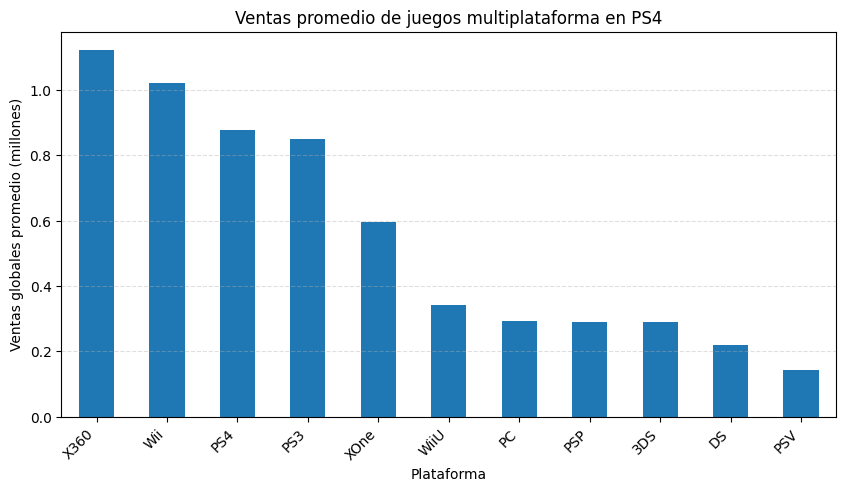

In [62]:
# Teniendo en cuenta tus conclusiones compara las ventas de los mismos juegos en otras plataformas.

multiplatform_games = df_games_filtered[df_games_filtered['name'].duplicated(keep=False)]
unique_multi_games = multiplatform_games['name'].nunique()
print(f'Total de juegos multiplataforma: {unique_multi_games}')

juegos_en_ps4 = df_games_filtered[df_games_filtered['platform'] == 'PS4']['name'].unique()

juegos_multi_ps4 = multiplatform_games[multiplatform_games['name'].isin(juegos_en_ps4)]

print(f'Juegos únicos que están en PS4 y otras plataformas: {juegos_multi_ps4["name"].nunique()}')
print(f'Total de registros (todas las plataformas): {len(juegos_multi_ps4)}')

ventas_por_plataforma = juegos_multi_ps4.groupby('platform')['global_sales'].mean().sort_values(ascending=False).head(11)

plt.figure(figsize=(10, 5))
ax = ventas_por_plataforma.plot(kind='bar')

ax.set_title('Ventas promedio de juegos multiplataforma en PS4')
ax.set_xlabel('Plataforma')
ax.set_ylabel('Ventas globales promedio (millones)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)

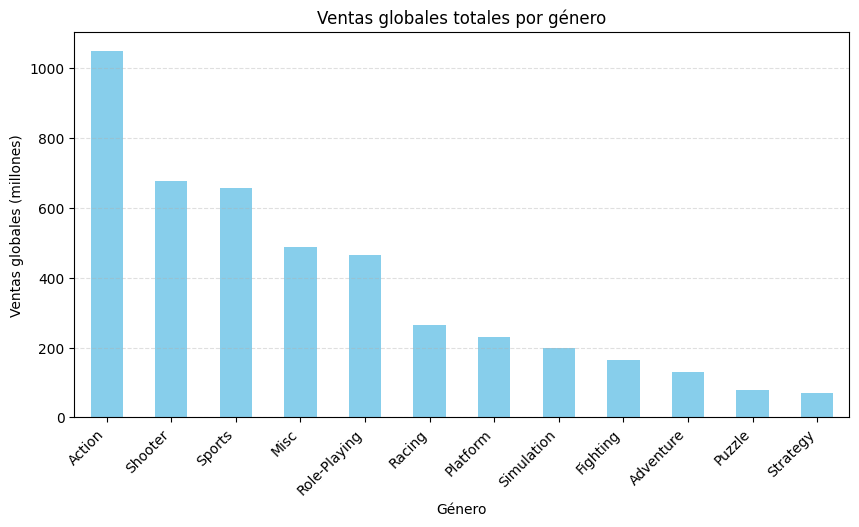

In [63]:
# Echa un vistazo a la distribución general de los juegos por género. 

games_per_genre = df_games_filtered.groupby('genre')['global_sales'].sum()
games_per_genre

plt.figure(figsize=(10, 5))
ax = games_per_genre.sort_values(ascending=False).plot(kind='bar', color='skyblue')

ax.set_title('Ventas globales totales por género')
ax.set_xlabel('Género')
ax.set_ylabel('Ventas globales (millones)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)

¿Qué se puede decir de los géneros más rentables? 

No podemos hablar de generos mas rentables o menos rentables ya que en el set de datos no tenemos información referente a costos de producción o margenes. Podemos analizar ventas pero los juegos mas vendidos no necesariamente son los mas rentables.

¿Puedes generalizar acerca de los géneros con ventas altas y bajas?

Los generos con mas ventas tienden a ser juegos que involucran un fuerte componente multijugador, competitivo y lanzamientos iterativos. 

Los generos que podemos considerar de "nicho" a pesar de tener ventas bajas, suelen ser mas rentables debido a sus bajos costos de producción por lo que suelen ser mas constantes.

## Paso 4. Crea un perfil de usuario para cada región

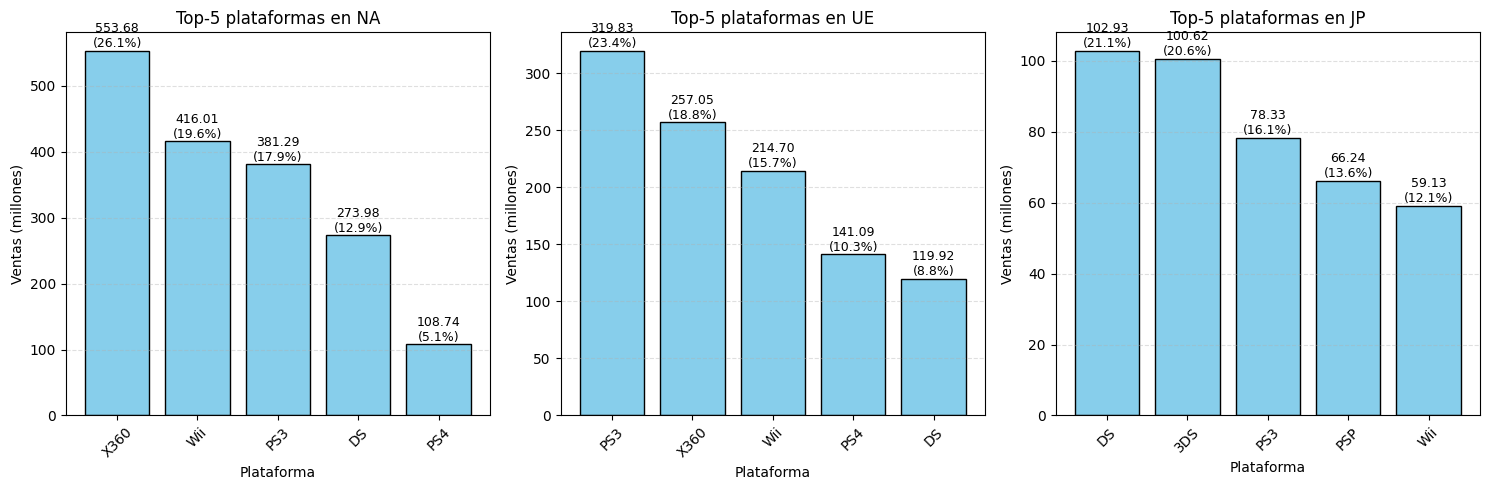

In [64]:
# Para cada región (NA, UE, JP) determina las cinco plataformas principales.

df_melted = df_games_filtered.melt(
    id_vars=['name', 'platform', 'genre'],
    value_vars=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'],
    var_name='region_raw',
    value_name='sales'
)

df_melted['sales'] = pd.to_numeric(df_melted['sales'], errors='coerce').fillna(0)

region_map = {
    'na_sales': 'NA',
    'eu_sales': 'UE',
    'jp_sales': 'JP',
    'other_sales': 'Other'
}
df_melted['region'] = df_melted['region_raw'].map(region_map)

ventas_por_region_plataforma = (df_melted
    .groupby(['region', 'platform'], as_index=False)['sales']
    .sum()
)

ventas_por_region_plataforma['total_region'] = (
    ventas_por_region_plataforma.groupby('region')['sales'].transform('sum')
)
ventas_por_region_plataforma['cuota_mercado'] = (
    100 * ventas_por_region_plataforma['sales'] / ventas_por_region_plataforma['total_region']
)

top5_con_cuotas = (ventas_por_region_plataforma
    .sort_values(['region', 'sales'], ascending=[True, False])
    .groupby('region')
    .head(5)
    .reset_index(drop=True)
)

top5_con_cuotas['cuota_mercado'] = top5_con_cuotas['cuota_mercado'].round(2)

regions = ["NA", "UE", "JP"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

for ax, reg in zip(axes, regions):
    data = (top5_con_cuotas[top5_con_cuotas['region'] == reg]
            .sort_values('sales', ascending=False))
    if data.empty:
        ax.set_axis_off()
        ax.set_title(f"{reg}: sin datos")
        continue

    bars = ax.bar(data['platform'], data['sales'], color='skyblue', edgecolor='black')
    ax.set_title(f"Top-5 plataformas en {reg}")
    ax.set_xlabel("Plataforma")
    ax.set_ylabel("Ventas (millones)")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

    for bar, share in zip(bars, data['cuota_mercado']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.2,
                f"{height:.2f}\n({share:.1f}%)",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

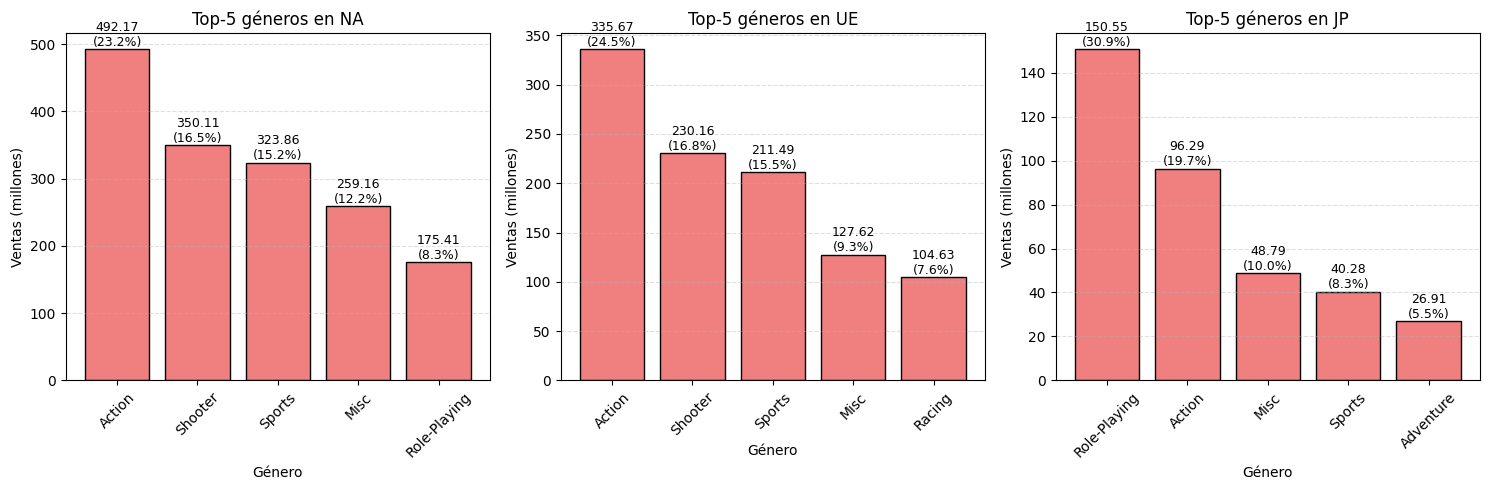

In [65]:
# Los cinco géneros principales. Explica la diferencia.

ventas_por_region_genero = (
    df_melted.groupby(['region', 'genre'])['sales']
    .sum()
    .reset_index()
)

top5_generos_region = (
    ventas_por_region_genero
    .sort_values(['region', 'sales'], ascending=[True, False])
    .groupby('region')
    .head(5)
    .reset_index(drop=True)
)

ventas_totales_genero_region = df_melted.groupby('region')['sales'].sum()
top5_generos_region['cuota_mercado'] = top5_generos_region.apply(
    lambda row: (row['sales'] / ventas_totales_genero_region[row['region']]) * 100,
    axis=1
)

regions = ["NA", "UE", "JP"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

for ax, reg in zip(axes, regions):
    data = (top5_generos_region[top5_generos_region['region'] == reg]
            .sort_values('sales', ascending=False))
    if data.empty:
        ax.set_axis_off()
        ax.set_title(f"{reg}: sin datos")
        continue

    bars = ax.bar(data['genre'], data['sales'], color='lightcoral', edgecolor='black')
    ax.set_title(f"Top-5 géneros en {reg}")
    ax.set_xlabel("Género")
    ax.set_ylabel("Ventas (millones)")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

    for bar, share in zip(bars, data['cuota_mercado']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.2,
                f"{height:.2f}\n({share:.1f}%)",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Norteamérica: prefiere acción rápida, multijugador y juegos deportivos.

Europa: combina acción, deportes y simulación, con gusto por títulos realistas.

Japón: se centra en historias, personajes y universos narrativos dentro de géneros de rol y aventura.

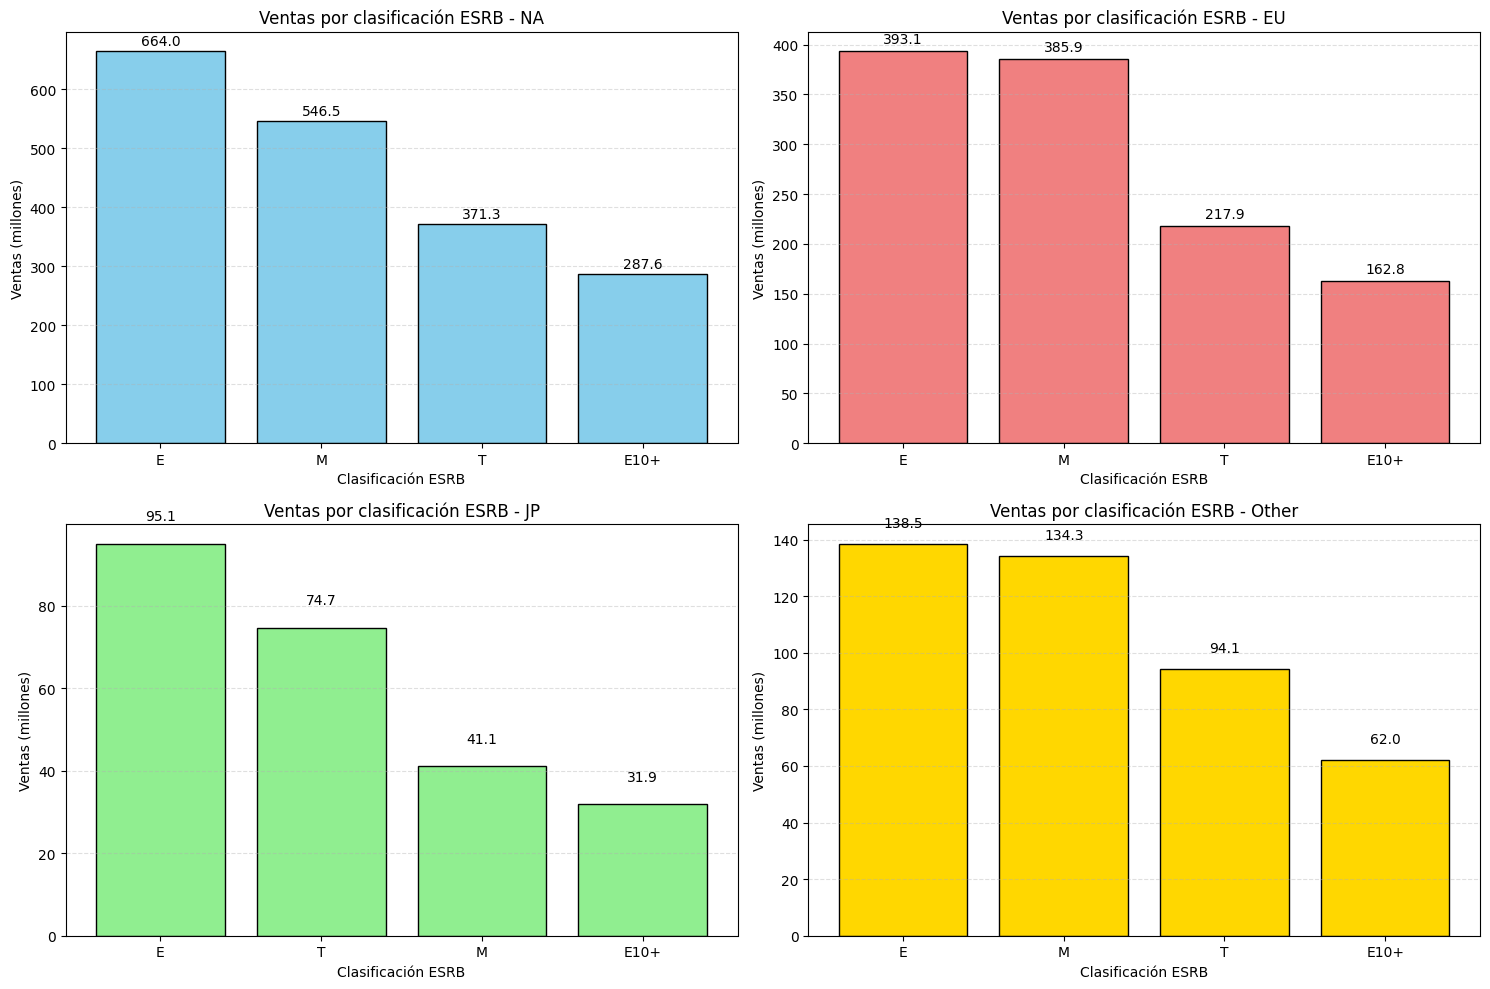

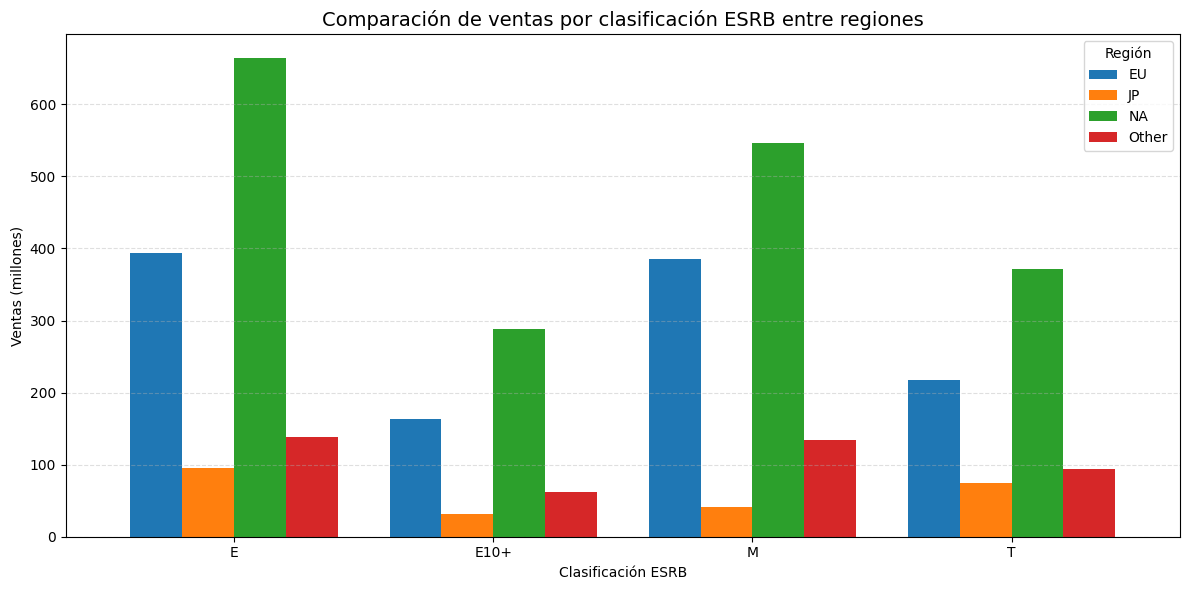

In [66]:
# Si las clasificaciones de ESRB afectan a las ventas en regiones individuales.

df_melted = df_games_filtered.melt(
    id_vars=['name', 'platform', 'genre','rating'],          
    value_vars=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'],  
    var_name='region_raw',                           
    value_name='sales'                               
)

ventas_rating_region = df_melted.groupby(['region_raw','rating'])['sales'].sum().reset_index()

region_map = {
    'na_sales': 'NA',
    'eu_sales': 'EU', 
    'jp_sales': 'JP',
    'other_sales': 'Other'
}
ventas_rating_region['region'] = ventas_rating_region['region_raw'].map(region_map)

ratings_significativos = ['E', 'E10+', 'T', 'M']
ventas_filtradas = ventas_rating_region[ventas_rating_region['rating'].isin(ratings_significativos)]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

regions = ['NA', 'EU', 'JP', 'Other']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

for i, region in enumerate(regions):
    data = ventas_filtradas[ventas_filtradas['region'] == region].sort_values('sales', ascending=False)
    
    if not data.empty:
        bars = axes[i].bar(data['rating'], data['sales'], color=colors[i], edgecolor='black')
        axes[i].set_title(f'Ventas por clasificación ESRB - {region}', fontsize=12)
        axes[i].set_xlabel('Clasificación ESRB')
        axes[i].set_ylabel('Ventas (millones)')
        axes[i].grid(axis='y', linestyle='--', alpha=0.4)
        
        for bar in bars:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2, height + 5,
                        f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
pivot_data = ventas_filtradas.pivot(index='rating', columns='region', values='sales')
pivot_data.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Comparación de ventas por clasificación ESRB entre regiones', fontsize=14)
plt.xlabel('Clasificación ESRB')
plt.ylabel('Ventas (millones)')
plt.legend(title='Región')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


## Paso 5. Prueba las siguientes hipótesis

In [67]:
# Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

alpha = 0.05

mask_xone = df_games_filtered['platform'].str.upper().isin(['XONE', 'XBOX ONE'])
mask_pc   = df_games_filtered['platform'].str.upper().isin(['PC'])

xone = df_games_filtered.loc[mask_xone, 'user_score'].dropna()
pc   = df_games_filtered.loc[mask_pc,   'user_score'].dropna()

print(f"N XOne={len(xone)}, media={xone.mean():.3f}")
print(f"N PC  ={len(pc)},   media={pc.mean():.3f}")

t_stat, p_val = st.ttest_ind(xone, pc, equal_var=False)

print(f"\nWelch t-test: t={t_stat:.3f}, p={p_val:.4f}, alpha={alpha}")
print("Conclusión:",
      "Rechazamos H0 (medias distintas)"
      if p_val < alpha else "No se rechaza H0 (no hay evidencia de diferencia)")

N XOne=182, media=6.521
N PC  =571,   media=6.765

Welch t-test: t=-2.022, p=0.0440, alpha=0.05
Conclusión: Rechazamos H0 (medias distintas)


In [68]:
# Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

alpha = 0.05

g_action = df_games_filtered[df_games_filtered['genre'] == 'Action']['user_score'].dropna()
g_sports = df_games_filtered[df_games_filtered['genre'] == 'Sports']['user_score'].dropna()

print(f"N Acción={len(g_action)}, media={g_action.mean():.3f}")
print(f"N Deportes={len(g_sports)}, media={g_sports.mean():.3f}")

t_stat, p_val = st.ttest_ind(g_action, g_sports, equal_var=False)

print(f"\nWelch t-test: t={t_stat:.3f}, p={p_val:.4f}, alpha={alpha}")
print("Conclusión:",
      "Rechazamos H0 (medias distintas)"
      if p_val < alpha else "No se rechaza H0 (no hay evidencia de diferencia)")

N Acción=1214, media=6.836
N Deportes=589, media=6.308

Welch t-test: t=6.661, p=0.0000, alpha=0.05
Conclusión: Rechazamos H0 (medias distintas)


Hipotesis 1

H₀: Las calificaciones promedio de los usuarios son iguales entre las plataformas Xbox One y PC.

H₁: Las calificaciones promedio de los usuarios son diferentes entre Xbox One y PC.

Sobre la primera hipotesis podemos concluir que existe evidencia de que la plataforma si influye en la calificación obtenida debido a los resultados obtenidos. sin embargo su efecto es minimo ya que la magnitud de esa diferencia es minima.

Hipotesis 2

H₀: Las calificaciones promedio de los usuarios son iguales entre los géneros Acción y Deportes.

H₁ (hipótesis alternativa): Las calificaciones promedio de los usuarios son diferentes entre Acción y Deportes.

En el caso de la segunda hipotesis los resultados tambien presentan diferencia significativa estadisticamente hablando. Además la diferencia en este caso es mayor por lo que podemos decir que el efecto de dicha diferencia tiene un impacto mayor.

Se utilizó la prueba t de Welch, para muestras independientes, pero que no asume varianzas iguales debido a que tenemos dos medias de grupos distintos y el tamaño de la muestra puede ser diferente. Además los datos son continuos.

En conjunto, estos resultados nos dicen que las preferencias de los usuarios presentan variaciones significativas dependiendo de la plataforma elegida y el genero del juego, aunque con distinta magnitud de efecto. Mientras que las diferencias entre plataformas son leves, las diferencias entre géneros muestran una preferencia por los juegos de acción.

## Paso 6. Escribe una conclusión general

El análisis de este set de datos muestra cómo ha evolucionado la industria en los últimos años. Pudimos observar el ciclo de vida promedio de las consolas en el mercado. Su desempeño en cuanto a la cantidad de titulos lanzados y su rentabilidad. 

Se observó un aumento importante en los lanzamientos durante los 2000, seguido de una caida a medida que se acerca el final del ciclo de vida de cada plataforma. Las consolas PS4, Xbox One y 3DS fueron las más exitosas en ventas recientes, mientras que PS2, Wii y DS aunque historicamente han sido las mas populares, han perdido relevancia en la actualidad. Los géneros Acción, Shooter y Deportes concentran la mayor parte de las ventas, y se encontró que las reseñas de usuarios y críticos influyen de forma positiva, aunque no definitiva en las ventas y rentabilidad.

En el análisis por región, se identificaron diferencias culturales claras: en Norteamérica destacan los juegos de acción y deportes; en Europa, los títulos de deportes y carreras; y en Japón, los de rol, acción y aventura. Las clasificaciones ESRB también afectan las ventas, pues las categorías E (para todos) y T (adolescentes) son las más populares, mientras que los juegos para adultos (M) tienen mayor aceptación en Occidente.

Las pruebas de hipótesis confirmaron estas tendencias. Se encontró una diferencia pequeña pero significativa en las calificaciones de usuarios entre Xbox One y PC (p = 0.044), y una diferencia clara entre los géneros Acción y Deportes (p < 0.001), a favor de los juegos de acción. En conjunto, los resultados muestran que el éxito de un videojuego depende tanto del tipo de juego como de la región y la plataforma, destacando la importancia de entender las preferencias del público para diseñar estrategias comerciales y de desarrollo más efectivas.